In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from proofreader.utils.vis import plot_3d
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from proofreader.data.cremi import prepare_cremi_vols

train_vols, test_vols = prepare_cremi_vols('../../dataset/cremi')

In [ ]:
from proofreader.data.splitter import NeuriteDataset
from proofreader.data.augment import Augmentor
num_slices = [4, 4]
radius = 96
context_slices = 4
num_points = 1024

augmentor = Augmentor(center=True, shuffle=True, normalize=[125, 1250, 1250])
train_dataset = NeuriteDataset(test_vols, num_slices, radius, context_slices, num_points=num_points, torch=True, open_vol=True, verbose=False, Augmentor=augmentor)
print(len(train_dataset))

In [ ]:
from torch.utils.data import DataLoader
import torch.nn as nn
config = get_config('cn_context_4_aug_small')
dataloader = DataLoader(dataset=train_dataset, batch_size=2, shuffle=True)
model, _ ,_ = build_full_model_from_config(config.model, config.dataset)
model = nn.DataParallel(model)
model = load_model(model, '../../330.ckpt', map_location=torch.device('cpu'))



In [ ]:
from proofreader.model.classifier import *
with torch.no_grad():
    count, acc = 0,0
    for step, batch in enumerate(dataloader):
        count += 1
        # get batch
        x, y = batch
        y_hat = model(x)
        pred = predict_class(y_hat)
        accs = get_accuracy(y, pred)
        print(accs)
        acc += accs['total_acc']
        print(round(acc/count, 3))


In [ ]:
def plot_example(x,y):
    lim = (-.1,.1)
    lim = (lim,lim,lim)
    pc = np.swapaxes(x, 0, 1)
    label = y.item() == 1
    plot_3d(pc, title=label, lims=lim)


In [ ]:
from proofreader.data.augment import Augmentor
from proofreader.utils.torch import load_model
from proofreader.model.config import *
from proofreader.model.classifier import *
from torch.utils.data import DataLoader
import torch.nn as nn

config = get_config('pointnet-pre-cs2')
ds_config = config.dataset

model = PointNet(num_points=2000, classes=2, batch_norm=True)
model = nn.DataParallel(model)
model = load_model(model, '../../750.ckpt', map_location=torch.device('cpu'))

augmentor = Augmentor(center=True, shuffle=True, normalize=[125, 1250, 1250])
num_slices = 1
tester = SliceDataset(test_vols, num_slices, 96, 2, 
                    num_points=2000, Augmentor=augmentor, verbose=False, drop_false=True, return_candidate_batch=True, randomize=True)


In [ ]:

with torch.no_grad():
    model.eval()
    neurites = 0
    seen = 0
    seen_correct = 0
    neurite_correct = 0
    for step, batch in enumerate(tester):
      
        # get batch
        x, y = batch

        for i in range(x.shape[0]): 
            y_hat = model(x[i].unsqueeze(dim=0))
            pred = predict_class(y_hat)
            true = int(pred == y[i])
            seen_correct += true
            seen += 1
            
            if pred == 1 or y[i] == 1:
                neurites += 1
                neurite_correct += true
                # if true == 0:
                #     plot_example(x[i],y[i])
                break

        if step % 10 == 0:
            print('seen acc:', seen_correct/seen, 'neurite acc:', neurite_correct/neurites)
            print(tester.get_stats())
        if step > 1000:
            break

print('seen acc:', seen_correct/seen)
print('neurite acc:', neurite_correct/neurites)
print(tester.get_stats())


In [58]:
import torch
from proofreader.utils.vis import *
import numpy as np

# for i in range(1,6):
#     print('NUM SLICES: ', i)
path = f'/mnt/home/jberman/ceph/pf/dataset/ns=2_r=128_cs=2_np=2048_dataset_train.pt'
X, Y = torch.load(f'{path}')


In [60]:
print(np.unique(x[:,0,:]))

[-0.016 -0.008  0.008  0.016]


In [ ]:
lens = []
for b in X:
    lens.append(len(b))
lens = np.array(lens)

# if Y[:,0][-1].item() != 1:
#     if Y[:,0].count_nonzero().item() != 0:
#         print(y[:,0])


for i in range(1,15):
    p = len(lens[lens==i])/len(lens)
    print(i, p)

make_histogram(lens, bins=50)

In [ ]:
# reset batch id
ts = 0
total = 0
for y in Y:
    ts += y[:,0].count_nonzero().item()
    total += len(y[:,0])

print(ts, ts/total)

In [ ]:
from proofreader.model.config import *
# merge canidate batches for testset
# reset batch id
for i in range(len(X)):
    y = Y[i]
    y[:,1] = i

test_dataset_merged = SimpleDataset(torch.cat(X), torch.cat(Y), shuffle=True)


In [ ]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset=test_dataset_merged, batch_size=256, drop_last=False, shuffle=True)

In [ ]:
from proofreader.model.classifier import *
ys, preds, bids = [], [] ,[]

for step, batch in enumerate(dataloader):
    # get batch
    x, y = batch
    bid = y[:, 1]
    y = y[:, 0]

    pred = torch.zeros_like(y)
    ys.append(y)
    preds.append(pred)
    bids.append(bid)


ys, preds, bids = torch.cat(ys), torch.cat(preds), torch.cat(bids)

uids = np.unique(bids)
batch_acc = {'neurite_acc': 0, 'seen_acc': 0}
print(uids)
for uid in uids:
    idxs = bids == uid
    print(ys[idxs], preds[idxs])
    accs = get_accuracy(ys[idxs], preds[idxs], ret_perfect=True)
    batch_acc['neurite_acc'] += accs['perfect']
    batch_acc['seen_acc'] += (accs['total_acc']*len(ys[idxs]))


batch_acc['neurite_acc'] /= len(uids)
batch_acc['seen_acc'] /= len(test_dataset_merged)
print(len(uids), len(test_dataset_merged))
print(batch_acc)

1399


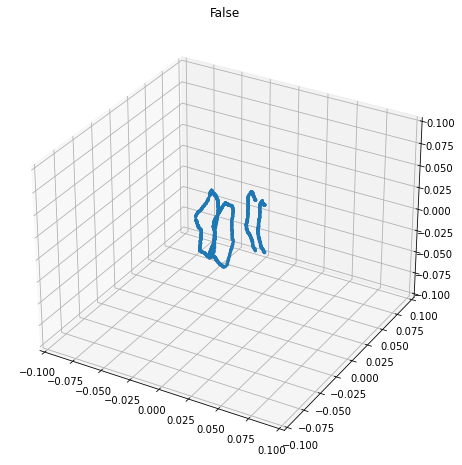

[-0.016 -0.008  0.008  0.016]


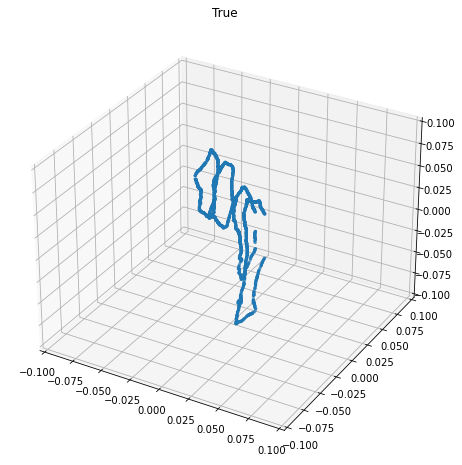

[-0.016 -0.008  0.008  0.016]


In [57]:
import random

i = random.randint(0,len(X))
x, y = X[i], Y[i]
print(i)
for j in range(len(x)):
    plot_example(x[j],y[j,0])
    print(np.unique(x[:,0,:]))


In [ ]:
from proofreader.utils.data import *
X, Y = equivariant_shuffle(X,Y)